## Use case: Using digitized glacier outlines and glacier extent data around the year 2000 CE for the estimation of the corresponding global glacier ice volumes and their sea level equivalent

## Quality assessment question: "What is the temporal distribution of the digitized glacier outlines, nominally provided for the year 2000 CE, and how well can they be used to estimate corresponding global glacier ice volumes?"

Glaciers are a major contributor to current global sea-level rise, a resource of fresh water, a potential threat of natural hazards, and an important factor for hydro-power production and runoff, as well as for recreation and tourism. A proper assessment of glacierized areas, glacier characteristics, as well as their changes due to warming climatic conditions therefore plays a crucial role in dealing with these issues. In that regard, the 'Glaciers distribution data from the Randolph Glacier Inventory (RGI) for year 2000' dataset provides key information with respect to glacier extent and their characteristics. The RGI dataset namely is a collection of digital glacier and ice cap outlines at the global scale, nominally provided for the year 2000 CE. As it is the most complete dataset of glacier outlines with a global coverage, researchers often take this data to represent the current state of all glaciers and it has therefore been used accordingly for an impressive amount of (modelling) studies as a reference dataset. However, although the goal of the dataset is to provide glacier outlines of all glaciers on Earth as close as possible to the year 2000, one of the main known issues of the dataset is the fact that the date of origin of the digitized glacier data varies substantially. This notebook investigates the corresponding temporal distribution of digitized glacier data and evaluates its implications for the estimation of current global glacier ice volumes using the example of Farinotti et al. (2019). 

## Quality assessment statement

- The glaciers distribution (‘Randolph Glacier Inventory’ or RGI) dataset on the Climate Data Store (CDS) (here version v6.0 is used) is currently the most complete dataset of glacier outlines in terms of its spatial coverage and is generally considered the main reference dataset to determine the glaciers distribution across the globe around the year 2000 CE.
- One of the typical problems with the data is the fact that not all digitized glacier information exactly corresponds to data in the year 2000 CE, as is nevertheless stated in the title of the dataset. Although most glaciers are digitized based on data sourcing from the timeframe between 2000 and 2010 CE, certain regions exhibit data that date back further in time, even until the 1940s. For a small percentage of glaciers, dates of digitization are furthermore missing.
- The long aggregation period of digitized glacier data should be kept in mind when determining glacier ice volume estimates based on RGI outlines (e.g. as done by Farinotti et al., 2019). This systematic error in the outlines namely has implications for glacier ice volume estimation: due to the observed worldwide shrinkage of the glacier area over the last several decades (e.g. Li et al., 2019; Zemp et al., 2019), a very likely underestimation of the glacierized area and ice volume estimate for 2000 CE occurs for glaciers digitized after 2000 CE, while else a very likely overestimation occurs.
- However, an estimate of the corresponding systematic error (at the global scale) related to outdated glacier outlines in the RGIv6.0 obtained in this notebook is found to only comprise a small percentage (<1%) of the total glacier ice volume estimate from Farinotti et al. (2019), implying that the dataset is well-suited to be used for glacier ice volume estimates at the global scale for the year 2000 CE.
- The under/overestimation effect is, however, highly glacier (and region) specific, as it depends on e.g. the glacier-specific time of digitization, the glacier volume response time (which is related to the local climatic regime and topographic/geometric glacier features), its debris-covered area (causing errors to the glacier outline), etc. Users should therefore revise case-specific details before computing glacier-specific or region/global-scale volume estimates with RGI outlines. This info can also be important for similar glaciological, hydrological, and climatological applications.

## Methodology

#### Short description

The dataset of the glaciers distribution on the Climate Data Store (CDS) is an almost complete collection of digital glacier and ice cap outlines and their geometrical/hypsometrical characteristics from various data sources at the global scale (RGI Consortium, 2017). The dataset on the CDS is considered a snapshot of glacier outlines around the year 2000 CE, assembled mainly from satellite images, and is based on the Randolph Glacier Inventory (RGI), which is currently the most complete dataset of glacier outlines. Simply stated, the glaciers in the dataset were automatically classified using the distinctive spectral reflectance signatures of snow and ice. During post-processing, raw glacier outlines are quality checked and manually corrected if required (e.g. in the case of a supraglacial debris cover). It also devides the glaciers into separate RGI regions, i.e. there are 19 of those regions ("clusters" of glaciers) in RGIv6.0. For a more detailed description of the data acquisition and processing methods, we refer to the documentation on the CDS or the ECMWF Confluence Wiki. The resulting glacier extent data can be downloaded in vector topology or as raster-based data. 

#### Structure and (sub)sections

In this notebook, the applicability of RGIv6.0 data to serve as an input for current global glacier ice volumes will be assessed by analyzing the temporal distribution of the dates of origin of the digitized glacier data, discussing the potential limitations and error sources of the dataset, and evaluating the implications for estimating current global glacier ice volumes based upon the example of Farinotti et al. (2019). Potential volume over/underestimation due to outdated glacier outlines will furthermore be quantified for each RGI region separately with the global glacier mass change data that are on the CDS. The structure is as follows:

- **Data preparation and processing**: This section loads packages, defines requests for download from the CDS, downloads the actual data and inspects the data to reveal its structure. Also the functions that are used in this notebook are defined in this section.
- **The (area-weighted) mean year of digitization of glacier data**: This section assesses how close the data of each of the glaciers is situated to the year 2000 CE. The spatial distribution of the year of ditigization is therefore analysed and plotted for each glacier. The arithmetic and area-weighted mean year of digitization are calculated for all RGI regions.
- **Other potential sources of error and uncertainty**: This section discusses additional limitations of the dataset, apart from the long aggregation period discussed earlier, that can be of importance for this specific use case.
- **Quantifying potential volume over- or underestimation due to outdated outlines**: This section estimates the potential over/underestimation of glacier surface areas and glacier ice volumes due to outdated outlines for each RGI region based on data from Farinotti et al. (2019). We therefore additionally make use of the "glacier mass change" dataset on the CDS. This section discusses and quantifies the suitability of the glacier extent data for this purpose.

## Analysis and results

### Data preparation and processing

First we load the packages:

In [106]:
import fsspec
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xesmf as xe
import xarray as xr
from scipy.optimize import curve_fit
import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/verhaegen_yoni/.cdsapirc")
from c3s_eqc_automatic_quality_control import download

plt.style.use("seaborn-v0_8-notebook")

Then we define requests for download from the CDS:

In [107]:
# Glacier extent data

request_extent = (
    "insitu-glaciers-extent",
    {
        "variable": "all",
        "format": "zip",
        "version": "6_0",
    },
)

# Glacier mass change data

period_start = "1975_1976"
period_stop = "2020_2021"
assert all("_" in period and len(period) == 9 for period in (period_start, period_stop))
y0_start, y1_start = map(int, period_start.split("_"))
y0_stop, y1_stop = map(int, period_stop.split("_"))

request_mass_change = (
    "derived-gridded-glacier-mass-change",
    {
        "variable": "glacier_mass_change",
        "product_version": "wgms_fog_2022_09",
        "format": "zip",
        "hydrological_year": [
            f"{y0}_{str(y1)[-2:]}"
            for y0, y1 in zip(
                range(y0_start, y0_stop + 1), range(y1_start, y1_stop + 1)
            )
        ],
    },
)

Next, we download the data. Since the data files to be downloaded and manipulated are quite large, this may take a couple of minutes.

In [108]:
# Get glacier extent data: takes a couple of minutes

print("Downloading and handling glacier extent data from the CDS, this may take a couple of minutes...")
df = download.download_and_transform(*request_extent).to_pandas()
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["CENLON"], df["CENLAT"]),
    crs="EPSG:4326",
)

print("Downloading glacier mass change data from the CDS...")
# Get glacier mass change data
ds = download.download_and_transform(
    *request_mass_change,
)
print("Download completed.")

100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


Download completed.


We define the functions to be used:

In [109]:
def plot_map(gdf, var_name=None, label=None, title=None, **kwargs):
    fig = plt.figure(figsize=(20,10))
    kwargs = {"markersize": 1, "legend": var_name is not None} | kwargs
    if var_name:
        kwargs = {"c": var_name, "column": var_name} | kwargs
        kwargs.setdefault("legend_kwds", {"shrink": 0.49, "extend": "both"})
        if label is not None:
            kwargs["legend_kwds"].setdefault("label", label)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gdf.plot(ax=ax, **kwargs)
    ax.axis("off")
    if title:
        ax.set_title(title, fontsize=15)
    return ax

def weighted_average(df, field_name, weights_name):
    df = df[df[field_name].notnull() & df[weights_name].notnull()]
    weights = df[weights_name]
    return (df[field_name] * weights).sum() / weights.sum()

def myExpFunc(x, a, b):
    return a * np.power(x, b)

Lastly, we can read and inspect the data. Let us print out the data to inspect its structure:

In [110]:
df

,C3S_ID,RGIID,GLIMSID,BGNDATE,ENDDATE,CENLON,CENLAT,O1REGION,O2REGION,AREA,ZMIN,ZMAX,ZMED,SLOPE,ASPECT,LMAX,NAME,geometry
index,,,,,,,,,,,,,,,,,,
0,C3S_000001,RGI60-01.00001,G213177E63689N,20090703,-9999999,-146.8230,63.6890,1,2,0.360,1936,2725,2385,42.0,346,839,None,POLYGON ((-146.81803943799997 63.6908060250000...
1,C3S_000002,RGI60-01.00002,G213332E63404N,20090703,-9999999,-146.6680,63.4040,1,2,0.558,1713,2144,2005,16.0,162,1197,None,POLYGON ((-146.66353681599998 63.4076384990000...
2,C3S_000003,RGI60-01.00003,G213920E63376N,20090703,-9999999,-146.0800,63.3760,1,2,1.685,1609,2182,1868,18.0,175,2106,None,POLYGON ((-146.07231695599998 63.3834750890000...
3,C3S_000004,RGI60-01.00004,G213880E63381N,20090703,-9999999,-146.1200,63.3810,1,2,3.681,1273,2317,1944,19.0,195,4175,None,POLYGON ((-146.14895308999996 63.3791882220000...
4,C3S_000005,RGI60-01.00005,G212943E63551N,20090703,-9999999,-147.0570,63.5510,1,2,2.573,1494,2317,1914,16.0,181,2981,None,POLYGON ((-147.04306686499996 63.5502401350000...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216424,C3S_216425,RGI60-19.02748,G322268E53986S,20020502,-9999999,-37.7325,-53.9860,19,3,0.042,310,510,-999,29.9,315,255,None,POLYGON ((-37.73275171199998 -53.9877898439999...
216425,C3S_216426,RGI60-19.02749,G323864E54831S,20030207,-9999999,-36.1361,-54.8310,19,3,0.567,330,830,-999,23.6,200,1130,None,POLYGON ((-36.138344003999975 -54.827345910999...
216426,C3S_216427,RGI60-19.02750,G322698E54188S,20030207,-9999999,-37.3018,-54.1884,19,3,4.118,10,1110,-999,16.8,308,4329,None,POLYGON ((-37.29308757999996 -54.1750637379999...


As can be seen above, the data includes attribute information for each individual glacier (i.e. digitized polygon) in the vector-type dataset. Important for this notebook are the `BGNDATE` and `ENDDATE` columns (YYYYMMDD format), which contain information about the time of ditigization of the specific glacier. As can already be seen, for some glaciers (part of) these data are missing and filled by `-9999999`. We will use this information below.

#### The (area-weighted) mean year of digitization of glacier data

We can begin to answer the user quesiton by extracting information from the attribute table of the downloaded shapefile. For some glaciers the outline is composed from several scenes over multiple years implying that a begin date (attribute "`BGNDATE`") and an end date (attribute "`ENDDATE`") is given in the attribute table in YYYYMMDD format (if both are available). For these glaciers, we calculate the mean of the begin and end year:

$
year_i = \textstyle\frac{BGNDATE_i + ENDDATE_i}{2}\ 
$

For other glaciers, we take the `BGNDATE` only:

$
year_ i = BGNDATE_i
$

In [111]:
# Convert dates from string to datetime, and add digitalization year
columns = []
for column in ("BGNDATE", "ENDDATE"):
    years = gdf[column].str[:4]
    months = gdf[column].str[4:6].replace("99", "01")
    days = gdf[column].str[6:8].replace("99", "01")
    date = years + months + days
    date = date.where(~date.str.startswith("-"))
    columns.append(pd.to_datetime(date))
dates = pd.DataFrame(columns).mean()
year = dates.dt.year.astype("Int64")
gdf["decimal_year"] = year + (dates.dt.dayofyear - 1) / (365 + dates.dt.is_leap_year)
gdf["year"] = year

This results in the following plots:

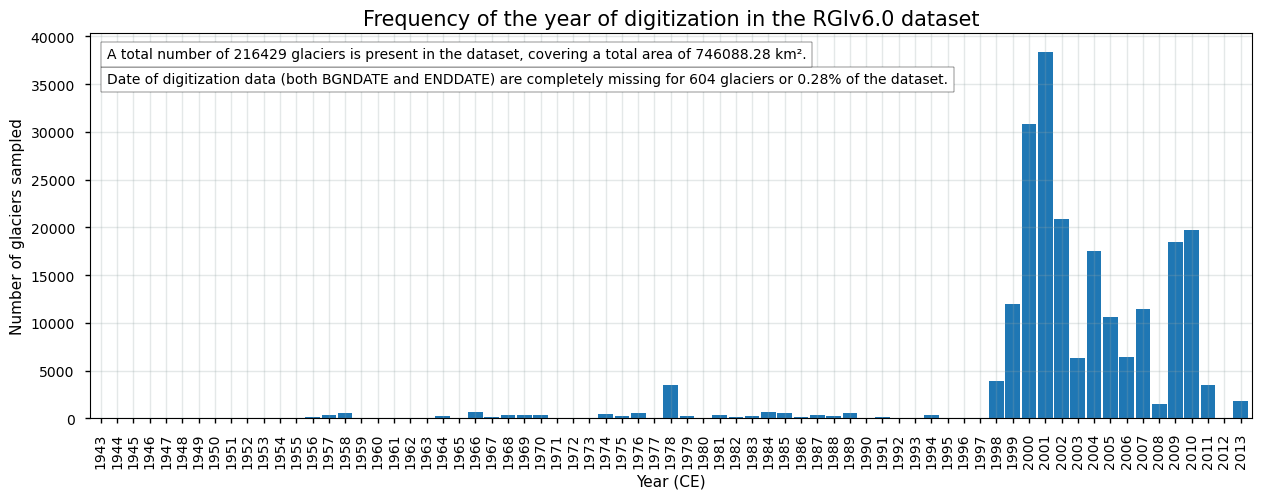

In [112]:
# Get data from years
size = gdf.set_index("year").groupby("year").size()
size = size.reindex(range(gdf["year"].min(), gdf["year"].max() + 1), fill_value=0)
missing = gdf["year"].isnull().sum()
missing_perc = 100 * (missing / len(gdf["year"]))
# Get some statistics
n_glaciers = len(gdf)
total_area = gdf["AREA"].sum()
# Plot data
ax = size.plot.bar(
    figsize=(15, 5),
    grid=True,
    width=0.9,
    ylabel="Number of glaciers sampled",
    xlabel="Year (CE)",
)
_ = ax.text(
    0.015,
    0.87,
    f"Date of digitization data (both BGNDATE and ENDDATE) are completely missing for {missing} glaciers or {missing_perc:.2f}% of the dataset.",
    transform=ax.transAxes,
    bbox={"facecolor": "white", "edgecolor": "black"},
);
_ = ax.text(
    0.015,
    0.935,
    f"A total number of {n_glaciers} glaciers is present in the dataset, covering a total area of {total_area:.2f} km².",
    transform=ax.transAxes,
    bbox={"facecolor": "white", "edgecolor": "black"},
);
ax.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax.set_title("Frequency of the year of digitization in the RGIv6.0 dataset",fontsize=15);

Let us check the spatial distribution of the year of digitization for each glacier in the dataset. We therefore produce a world map where every dot represents a glacier, that is colored according to its year of digitization. Glaciers with missing data are not plotted:

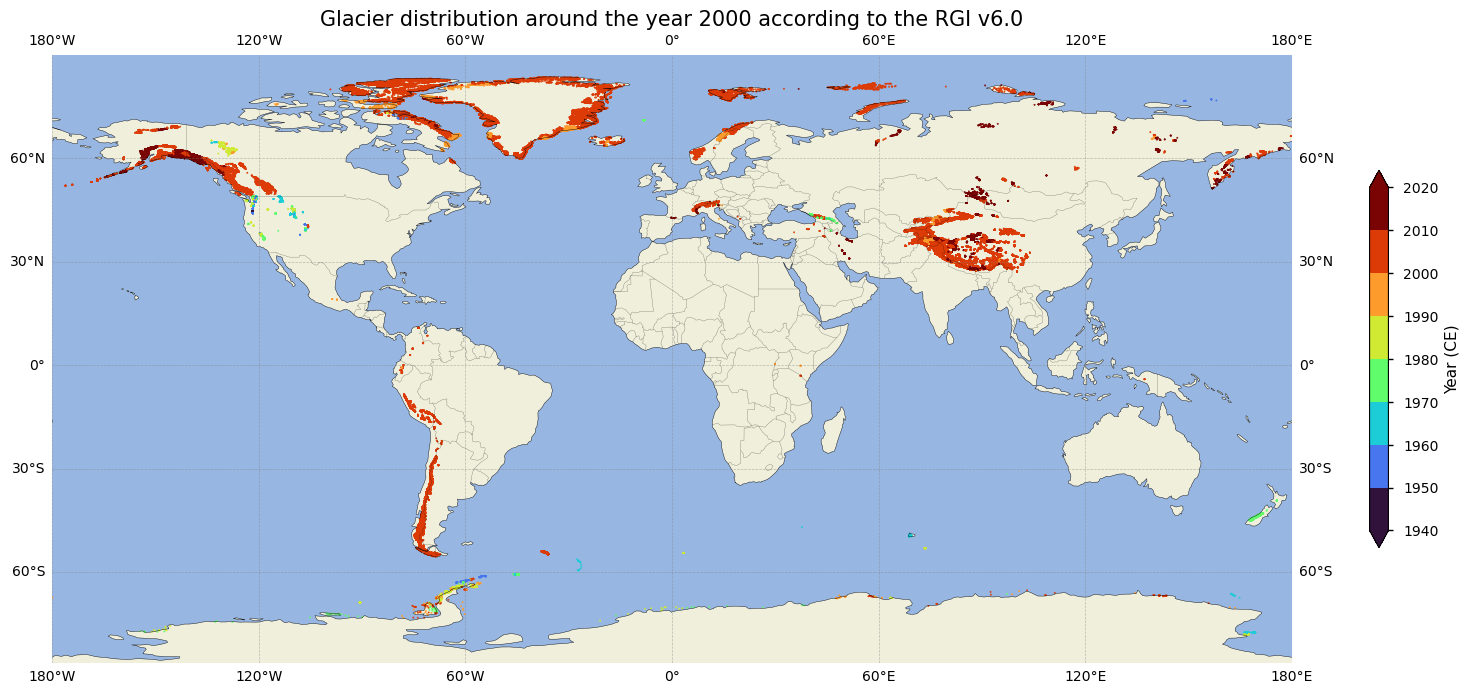

In [113]:
cmap = mpl.cm.turbo
norm = mpl.colors.BoundaryNorm(range(1940, 2021, 10), cmap.N)
ax = plot_map(
    gdf,
    var_name="year",
    cmap=cmap,
    norm=norm,
    label="Year (CE)",
    title="Glacier distribution around the year 2000 according to the RGI v6.0",
)

From the above plots, it becomes clear that not all glaciers are digitized in the year 2000 CE. Although the dataset is intended to be a snapshot of the world’s glaciers as they were near the beginning of the 21st century, the user must keep in mind that the range of digitization dates is substantial. This means that the outlines do not all lie in the same time frame, which is a main issue of the dataset. The figures above demonstrate that most outlines originate from the period between 2000 and 2010 CE. However, for some areas like New Zealand, the Caucasus or the western United States, the glacier outlines date back to the 1970s or earlier. The dataset is intended to be representative for “around the year 2000 CE”, while in fact the temporal coverage of the outlines from individual glacier ranges from the 1940s into the 2010s CE. The large heterogeneity with respect to the year of digitization of the glacier outlines is a major limitation of the dataset and the user should take note of that before using a specific glacier outline. 

We can also quantify this and calculate the average and area-weighted average time of digitization, for the dataset as a whole but also for each of the different 19 RGI regions:

Arithmetic mean:
$
\overline{year}_a = \textstyle\frac{1}{n}{\sum_{i=1}^n year_i}
$
with 
$
n
$
the total number of glaciers in the dataset.

Area-weighted mean:
$
\overline{year}_w = \textstyle\frac{1}{\sum_{i=1}^n A_i} {\sum_{i=1}^n (A_i*year_i)}
$
where
$
A_i
$
is the glacierized area for glacier $i$ [km²].

This results in the following plot:

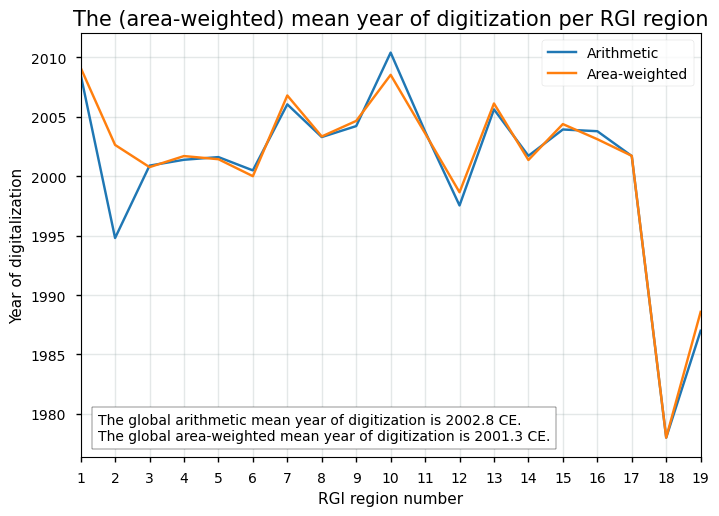

In [114]:
gdf["region"] = gdf["RGIID"].str[6:8].astype(int)
grouped = gdf[["year", "decimal_year", "AREA", "region"]].groupby("region")
ungrouped = gdf[["year", "decimal_year", "AREA", "region"]]
total_area = (grouped["AREA"].sum())
means = {
    "Arithmetic": grouped["decimal_year"].mean(),
    "Area-weighted": grouped.apply(
        weighted_average, "decimal_year", "AREA", include_groups=False
    ),
}
for label, mean in means.items():
    ax = mean.plot(label=label)
ax.set_xlabel("RGI region number")
ax.set_ylabel("Year of digitalization")
ax.legend()
textstr = '\n'.join((
    'The global arithmetic mean year of digitization is %.1f CE.' % (gdf["decimal_year"].mean(), ),
    'The global area-weighted mean year of digitization is %.1f CE.' % (mean.mean()),
));
ax.text(1.5, 1977.8, textstr, bbox={"facecolor":"white","edgecolor":"black"});
ax.set_xticks(np.linspace(1,max(gdf["region"]),max(gdf["region"])))
ax.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax.set_xlim(np.min(gdf["region"]),np.max(gdf["region"]))
ax.set_title("The (area-weighted) mean year of digitization per RGI region",fontsize=15);

We observe that at the global scale, the area-weighted average of the year of digitization is close to 2001 CE, which only slighly differs in time from the nominally stated dataset reference time (i.e. 2000 CE). However, the (area-weigthed) average of the time of digitization varies notably across the different RGI regions: for New Zealand (RGI region 18), for example, the area-weighted average is 1978 CE, for Alaska (RGI region 1) it is close to 2009 CE.

#### Other potential sources of error and uncertainty

Apart from a substantial deviation of the derived glacier data to the year 2000 CE, other potential sources of uncertainty include a low resolution and quality of the source data, a poor skill of the digitizer, the presence of shadow or clouds on the satellite images, poor availability of multi-temporal satellite images, the presence of proglacial lakes, and the presence of seasonal snow fields. The largest source of misdelineation of glaciers is, however, the presence of supraglacial debris. For glaciers with extensive debris cover or for rock glaciers, the accuracy can therefore be significantly impacted (Paul et al., 2013). This is related to the fact that the spectral signature of debris is very similar to that of the surrounding moraines and bedrock. In regions with large debris cover (e.g. High Mountain Asia or the Caucasus), the user should be aware that the glacier area can be significantly underestimated due to the presence of debris. 

Another issue of the dataset is the unclear interpretation of what a glacier is. As the glacier outlines were created by a globally diverse community, the interpretation of what a glacier or ice cap is (do ice walls need to be included, how do tributaries need to be treated, which type of glaciers should be added, how to divide glacier complexes into separate entities, from which threshold size onwards can we speak of a glacier) deviates among data sources. In this context, debris-covered/rock glaciers (where it is difficult to distinguish debris-covered ice from bedrock) and also the peripheral glaciers of Antarctica and Greenland (where it is difficult to distinguish (outlet) glaciers from the main ice sheet bodies) remain a struggle (Hock et al., 2022). Specific attention of the user is therefore required in these areas. Ice bodies smaller than a regionally variable threshold size were furthermore not added (as being the supposed minimum size for ice flow and also to exclude (seasonal) snow fields). This implies that in some regions, glaciers smaller than this threshold were not included in the dataset, which leads to an underestimation of the glacier surface (RGI Consortium, 2017). The total number of glaciers (and the total surface area covered by glaciers) in the dataset is therefore a rather arbitrary quantity. Further investigation also reveals that especially glacier surface extent data in RGI region 14 and 15 (South Asia West and South Asia East) are significantly underestimated in the gridded version of the dataset when compared to the vector counterpart used in this notebook (i.e. up to >50% in RGI region 15 (Li et al., 2021)). Although this is out of scope for this specific notebook, the user should take extra care in these regions. 

Quantitative estimates of the errors and the related uncertainty are not given in the data. However, an error model can be found in Pfeffer et al. (2014). Here, it is stated that the relative error of the glacier area is larger for small glaciers than for large glaciers because small glaciers have a larger outline to area ratio. Based on the above, the uncertainty of an individual glacier outline, supposingly being representative for 2000 CE, therefore depends upon both the quality of the source material and the characteristics of the specific glacier.

#### How well can the data be used to estimate current global glacier ice volumes?

Going back to our specific use case, it is worth noting that several methods exist in the literature to derive ice thickness and ice volume estimates of glaciers at different spatial scales, of which the most well-known procedures are the volume-area scaling method, numerical modelling, and the estimation of ice thicknesses from surface characteristics and the principle of ice dynamics. These methods, however, strongly rely on the precise determination of the glacier surface area (and hypsometry) to derive total ice volume estimates. Farinotti et al. (2019) used the latter method to derive a consensus estimate of global ice thickness values and the current global glacier ice volume for all glaciers digitized in the RGIv6.0 dataset. They found a total global glacier ice volume of 158.17 ± 41.03 × 10³ km³. The authors stated that the quality of their ice volume estimates highly depends upon the quality of the input data. Other studies using (earlier versions of) the RGI glacier extent data to derive regional or global glacier ice volumes report the same concerns and general sources of uncertainty in the input data (e.g. Huss and Farinotti, 2012; Marzeion et al., 2012; Milan et al., 2022).

Although the RGIv6.0 data do not include information on temporal changes of the glacier extent, Zemp et al. (2015),  Li et al. (2019) and Zemp et al. (2019) concluded that glacier retreat has been dominant during the last several decades, with the 21st century marking the historical minimum glacier extent in almost all regions across the globe since at least the 1500s. Results from Li et al. (2019) show that during the period 1980–2015, the rate of global glacier area change was -0.18% per year. Zemp et al. (2019) estimates this number to be -0.34% per year between 1961-2016. From a global record of 471 glacier length change data, Leclerq et al. (2014) furthermore found a median retreat rate over the 1961-2000 period of 7.4 meter per year. These findings indicate rapidly changing glacier conditions (and outlines), with observed glacier shrinkage and retreat in every RGI region during the last several decades (Li et al., 2019). The observed changes of the glacierized area from the literature imply a very likely overestimation of the volume estimate for glaciers digitized before 2000 CE (e.g. New Zealand), and an underestimation else (e.g. Svalbard). The actual retreat and shrinkage (i.e. volume response time) of individual glaciers, however, is dictated by both geometric/topographic factors, such as the slope and the initial glacier size, and on local climatic conditions (Zemp et al., 2015). Eventually, the suitability of RGI outlines to be used for current glacier ice volume estimation therefore depends on the magnitude of the deviation of the time of digitization from the year 2000 CE and the glacier area change, that would have potentially affacted the outlines, between 2000 CE and this deviation. 

Some studies have also investigated the choice of the glacier inventory on glacier ice volume estimates. For example, Li et al. (2022) found differences in ice volume of 2 to 8% in the Tien Shan when comparing two different glacier inventories, one of them being the RGIv6.0. Van Wyk de Vries et al. (2022) concluded that RGIv6.0 polygons overestimate the spatial extent of the majority of glaciers in the Northern Andes, likely due to rapid recent glacier recession, leading them to correct the outlines for their estimates. Bahr and Radić (2012) furthermore found that the omission of glaciers <0.01 km² (as done in the RGIv6.0) can lead to errors in regional ice volume of up to 10%. At last, Huss and Farinotti (2012) quantified the bulk uncertainties in their ice volume calculation due to imperfections in the (earlier-version) RGI shapes as varying between 1 and 8%, depending on the RGI region. Farinotti et al. (2019) did not perform any sensitivity experiment regarding the glacier outlines.

#### Quantifying potential volume over- or underestimation due to outdated outlines

One way of quantifying the potential over- or underestimation of global glacier ice volumes relative to the year 2000 CE, due to not taking into account temporally changing glacier outlines, is to use the glacier mass change dataset that is on the CDS. The dataset estimates the gridded yearly mass loss of glacier ice at the global scale in Gt, which can be easily converted to km³ of ice. Since this dataset takes into account (a parameterization of) the rate of change of the glacierized area for each RGI region from Zemp et al. (2019) to derive their corresponding mass changes, the data can be used to quantify the over- or underestimation of the glacier volume if the deviation of the area-weighted average time of digitization to the year 2000 CE for a particular RGI region is known. We therefore calculate the cumulative volume loss between 2000 CE and the area-weighted average year of digitization (as calculated above) between each RGI region by using the "Glacier mass change gridded data from 1976 to present derived from the Fluctuations of Glaciers Database". We make use of a conversion factor for $\Delta M$ of 1 Gt = 1.091 km³ of ice. The corresponding formula is for a single RGI region is: 

$
\Delta{V_{region}} 
$
[km³]
$
= (\frac{\rho_w}{\rho_i}) * \sum_{i={2000}}^{{\overline{year}_w}} \sum^{x,y} (\Delta M_{x,y,i})
$
, where $\rho_w$ and $\rho_i$ are the densities of water and ice respectively, $\Delta {M_{x,y,i}}$ is the glacier mass change (in Gt) at pixel $x,y$ at a certain year $i$ and lastly, $\Delta{V}$ is the total volume over/underestimation.

For the corresponding uncertainty, we apply the formula of erorr propagation in both space and time, hereby assuming that errors are independent and hence uncorrelated:

$
\sigma_{\Delta{V_{region}}}
$
[km³]
$
= (\frac{\rho_w}{\rho_i}) * \sqrt{\sum_{i={2000}}^{{\overline{year}_w}} (\sqrt{\sum^{x,y}(\sigma_{ \Delta {M_{x,y,i}}})^2})^2}
$
, where $\sigma_{ \Delta {M_{x,y,i}}}$ is the mass change uncertainty (in Gt) at pixel $x,y$ at a certain year $i$.

If ${{\overline{year}_w}}$ is a decimal year, we use linear interpolation to find the interpolated glacier mass change and uncertainty. Let us apply this to the 19 different RGI regions in the RGIv6.0 dataset:

In [115]:
# Mask data for RGI regions
regions = gdf["RGIID"].str[6:8].astype(int)
da = regions.to_xarray().assign_coords(
    lon=gdf["CENLON"].to_xarray(),
    lat=gdf["CENLAT"].to_xarray(),
)
regridder = xe.Regridder(da, ds, locstream_in=True, method="nearest_s2d")
mask_2d = regridder(da)
mask = xr.concat(
    [(mask_2d == region).expand_dims(region=[region]) for region in regions.unique()],
    "region",
)
ds = ds.where(mask)

# Compute cumulative fields
#ds = ds.sum(("latitude", "longitude"), keep_attrs=True)
ds["time"] = ds["time"].dt.year
ds["time"].attrs |= {"long_name": "Time", "units": "yr"}
for da in ds.data_vars.values():
    da.attrs["units"] += " $yr^{-1}$"
    da.attrs["long_name"] = da.attrs["long_name"].replace("_", " ").title()

# Mass change
cumulative = (ds["Glacier"].sum(("latitude","longitude"),keep_attrs=True)).cumsum("time")
cumulative.attrs = {
    "units": ds["Glacier"].attrs["units"].split()[0],
    "long_name": f"Cumulative {ds['Glacier'].attrs['long_name']}",
}
ds["Cumulative"] = cumulative

# Uncertainty
cumulative_err = ((ds["Uncertainty"]**2).sum(("latitude","longitude"),keep_attrs=True)) ** 0.5  # Error in space
cumulative_err = ((cumulative_err**2).cumsum("time")) ** 0.5  # Error in time
cumulative_err.attrs = {
    "units": ds["Uncertainty"].attrs["units"].split()[0],
    "long_name": f"Cumulative {ds['Uncertainty'].attrs['long_name']}",
}
ds["Cumulative_err"] = cumulative_err
    
# Calculate volume under- or overestimation
year = 2000
original = ds.reset_coords()["Cumulative"]
original_err = ds.reset_coords()["Cumulative_err"]
interpolated = original.interp(time=means["Area-weighted"].to_xarray())
interpolated_err = original_err.interp(time=means["Area-weighted"].to_xarray())
estimate = 1.091 * (interpolated - original.sel(time=year)).compute()
estimate_err = 1.091 * (interpolated_err - original_err.sel(time=year)).compute()
# Do the loop
for region, result, err in zip(estimate.region.values, estimate.values, estimate_err.values):
    print(
        f"The volume estimate in RGI region {region:>2}"
        f" for the year {year} CE is"
        f" {'under' if result < 0 else 'over':>5}estimated"
        f" by {abs(float(result)):.2f} ± {abs(float(err)):.2f} km³."
    )

total = estimate.sum()
total_err = abs(estimate_err).sum()
print(
    f"\nThe volume estimate at the global scale"
    f" for the year {year} CE is"
    f" {'under' if result <0 else 'over'}estimated"
    f" by {abs(float(total)):.2f} ± {abs(float(total_err)):.2f} km³."
)

The volume estimate in RGI region  1 for the year 2000 CE is underestimated by 556.24 ± 7.40 km³.
The volume estimate in RGI region  2 for the year 2000 CE is underestimated by 23.95 ± 0.19 km³.
The volume estimate in RGI region  3 for the year 2000 CE is underestimated by 13.27 ± 0.68 km³.
The volume estimate in RGI region  4 for the year 2000 CE is underestimated by 30.19 ± 0.60 km³.
The volume estimate in RGI region  5 for the year 2000 CE is underestimated by 46.84 ± 1.48 km³.
The volume estimate in RGI region  6 for the year 2000 CE is underestimated by 0.09 ± 0.00 km³.
The volume estimate in RGI region  7 for the year 2000 CE is underestimated by 92.90 ± 2.39 km³.
The volume estimate in RGI region  8 for the year 2000 CE is underestimated by 11.83 ± 0.06 km³.
The volume estimate in RGI region  9 for the year 2000 CE is underestimated by 72.70 ± 2.86 km³.
The volume estimate in RGI region 10 for the year 2000 CE is underestimated by 11.09 ± 0.06 km³.
The volume estimate in RGI reg

Here, it is clear that especially RGI regions 1 (Alaska) and 19 (Antarctic and Subantarctic) exhibit a relatively large underestimation of the total glacier ice volume, mainly due to their large deviation of the  area-weighted average year of digitization to the year 2000 CE, as well as the large glacier ice volume changes during this corresponding period. At the global scale, glacier ice volume estimates would exhibit an underestimation of ca. 1200 km³ due to outdated glacier outlines, which is only ca. 0.75% of the total glacier ice volume estimate by Farinotti et al. (2019). Glacier ice volumes are only overestimated in RGI regions 12 (Caucasus and Middle East) and 18 (New Zealand). Percentage-wise, the highest deviation relative to the total glacier ice volume in a certain region occurs in RGI region 10 (North Asia ~ in the order of 8%). At the global scale, the above obtained deviation related to the outdated glacier outlines from RGIv6.0 is thus relatively low when compared to the total global glacier ice volume estimate from Farinotti et al. (2019), implying that the dataset is well-suited to estimate current global glacier ice volumes for the year 2000 CE. The corresponding systematic error is, however, glacier- and region-dependent.

In fact, we can re-use the volume under/overestimation above to get an idea of the surface area under/overestimation through a common technique called volume-area scaling for glaciers (e.g. Bahr et al., 1997). The corresponding formula scales the surface area $A$ to the total glacier volume $V$ through a power law:

$
V_{region} = cA_{region}^{\gamma}
$
where $c$ [km$^{3-2{\gamma}}$] and $\gamma$ [-] are constants.

If we know the glacier volume change in a region, we can covert this information to glacier area changes according to:

$
\frac{dV_{region}}{dA_{region}} = c{\gamma}A_{region}^{{\gamma}-1}
$
so that
$ dA_{region} = \frac{dV_{region}}{c{\gamma}A_{region}^{{\gamma}-1}}
$

Let us find values for $c$ and ${\gamma}$ with surface areas from RGIv6.0 (as derived above) and the corresponding volume estimates from Farinotti et al. (2019) and calculate the expected surface area under/overestimation in each RGI region based on the volume changes:

In [116]:
total_volume = (18980, 1060, 28330, 8610, 15690, 3770, 7470, 300, 14640, 140, 130, 60, 3270, 2870, 880, 100, 5340, 70, 46470) # From Farinotti et al. (2019)
x = total_area.values
y = total_volume
popt, pcov = curve_fit(myExpFunc, x, y)
dA = ((estimate.values)) / (popt[0]*popt[1]*((np.abs(total_area.values))**(popt[1]-1)))

# Print values
for i, value in enumerate(dA):
    print(f"The glacierized area in region {i+1:>2} " 
          f"for the year {year} CE is"
          f" {'under' if value <0 else 'over':>5}estimated"
          f" by {np.abs(value):.2f} km²."
)

The glacierized area in region  1 for the year 2000 CE is underestimated by 1979.16 km².
The glacierized area in region  2 for the year 2000 CE is underestimated by 138.06 km².
The glacierized area in region  3 for the year 2000 CE is underestimated by 44.82 km².
The glacierized area in region  4 for the year 2000 CE is underestimated by 131.61 km².
The glacierized area in region  5 for the year 2000 CE is underestimated by 149.39 km².
The glacierized area in region  6 for the year 2000 CE is underestimated by 0.53 km².
The glacierized area in region  7 for the year 2000 CE is underestimated by 425.75 km².
The glacierized area in region  8 for the year 2000 CE is underestimated by 104.85 km².
The glacierized area in region  9 for the year 2000 CE is underestimated by 297.61 km².
The glacierized area in region 10 for the year 2000 CE is underestimated by 103.82 km².
The glacierized area in region 11 for the year 2000 CE is underestimated by 47.79 km².
The glacierized area in region 12 f

Summing up those data for all regions yields the total systematic error of the global glacierized surface area with respect to the year 2000 CE:

$
\Delta A
$
[km²]
$
= \sum_{i=1}^{n} dA_{region}
$
where
$
n
$
denotes the number of RGI regions, i.e. 19 and $\Delta A$ is the total glacier area over/underestimation [km²]. 

This results in:

In [118]:
print(f"The total glacierized surface area in RGIv6.0 for the year {year} CE is"
      f" {'under' if np.sum(dA) < 0 else 'over'}estimated"
      f" by {abs(np.sum(dA)):.2f} km² or {100*(abs(np.sum(dA))/total_area.sum()):.2f}% of the total glacierized area in the dataset."
)

The total glacierized surface area in RGIv6.0 for the year 2000 CE is underestimated by 4608.60 km² or 0.62% of the total glacierized area in the dataset.


We conclude that there is an underestimation of the glacier surface area for the year 2000 CE in the RGIv6.0 dataset, which is to be expected by the values of the area-weighted average year of digitization. The underestimation is, however, relatively small compared to the total global surface area estimate (< 1%) and can hence be assumed to be of minor influence for applications on the global scale. Again, the systematic error is, however, glacier- and region-dependent.

## If you want to know more

### Key resources

- "Glaciers distribution data from the Randolph Glacier Inventory for year 2000" on the CDS
- "Glacier mass change gridded data from 1976 to present derived from the Fluctuations of Glaciers Database" on the CDS

### References

- Bahr, D. B., Meier, M. F., and Peckham, S. (1997). The physical basis of glacier volume-area scaling. Journal of Geophysical Research, 102(B9), 20355–20362, doi: 10.1029/97JB01696.

- Farinotti, D., Huss, M., Fürst, J. J., Landmann, J., Machguth, H., Maussion, F., and Pandit, A. (2019). A consensus estimate for the ice thickness distribution of all glaciers on Earth. Nature Geoscience, 12(3), 168-173. doi: 10.1038/s41561-019-0300-3.

- Hock, R., Maussion, F., Marzeion, B., and Nowicki, S. (2022). What is the global glacier ice volume outside the ice sheets? Journal of Glaciology, 69(273), 204–10. doi: 10.1017/jog.2023.1.

- Huss, M., and Farinotti, D. (2012). Distributed ice thickness and volume of all glaciers around the globe, Journal of Geophysical Research, 117, F04010. doi: 10.1029/2012JF002523.

- Leclercq, P. W., Oerlemans, J., Basagic, H. J., Bushueva, I., Cook, A. J., and Le Bris, R. (2014). A data set of worldwide glacier length fluctuations, Cryosphere, 2014(8), 659–672. doi: 10.5194/tc-8-659-2014.

- Li, Y. J., Ding, Y. J., Shangguan, D. H., and Wang, R. J. (2019). Regional differences in global glacier retreat from 1980 to 2015, Advances in Climate Change Research, 10(4), 203–213. doi: 10.1016/j.accre.2020.03.003.

- Li, Y. J., Li, F., Shangguan, D. H., Ding, Y. J. (2021). A New Global Gridded Glacier Dataset Based on the Randolph Glacier Inventory Version 6.0. Journal of Glaciology, 67 (2021), 773–76. doi: 10.1017/jog.2021.28.

- Li, F., Maussion F., Wu, G., Chen, W., Yu, Z., Li, Y., and Liu, G. (2022). Influence of glacier inventories on ice thickness estimates and future glacier change projections in the Tian Shan range, Central Asia. Journal of Glaciology 1–15. doi: 10.1017/jog.2022.60.

- Marzeion, B., Jarosch, A. H., and Hofer, M. (2012). Past and future sea-level change from the surface mass balance of glaciers, The Cryosphere, 6, 1295–1322. doi: 10.5194/tc-6-1295-2012.

- Millan, R., Mouginot, J., Rabatel, A., and Morlighem, M. (2022). Ice velocity and thickness of the world’s glaciers, Nature Geoscience, 15, 124–129. doi: 10.1038/s41561-021-00885-z.

- Paul, F., Barrand, N. E., Baumann, S., Berthier, E., Bolch, T., Casey, K., Frey, H., Joshi, S. P., Konovalov, V., Le Bris, R., Mölg, N., Nosenko, G., Nuth, C., Pope, A., Racoviteanu, A., Rastner, P., Raup, B., Scharrer, K., Steffen, S., and Winsvold, S. (2013). On the Accuracy of Glacier Outlines Derived from Remote-Sensing Data. Annals of Glaciology, 54(63), 171–82. doi: 10.3189/2013AoG63A296.

- Pfeffer, W. T., Arendt, A. A., Bliss, A., Bolch, T., Cogley, J. G., Gardner, A. S., Hagen, J. O., Hock, R., Kaser, G., Kienholz, C., Miles, E. S., Moholdt, G., Mölg, N., Paul, F., Radić, V., Rastner, P., Raup, B. H., Rich, J., Sharp, M. J., and Glasser, N. (2014). The Randolph Glacier Inventory: A globally complete inventory of glaciers, Journal of Glaciology, 60(221), 537-552. doi: 10.3189/2014JoG13J176.

- RGI Consortium (2017). Randolph Glacier Inventory – A Dataset of Global Glacier Outlines: Version 6.0: Technical Report, Global Land Ice Measurements from Space, Colorado, USA. Digital Media. doi: 10.7265/N5-RGI-60.

- Zemp, M., Frey, H., Gärtnew-Roer, I., Nussbaumer, S. U., Helzle, M., Paul, F., Haeberli, W., Denzinger, F., Ahlstrøm, A. P., Anderson, B., Bajracharya, S., Baroni, C., Braun, L. N., Cáceres, B. E., Casassa, G., Cobos, G., Dávila, L. R., Delgado Granados, H., Demuth, M. N., Espizua, L., Fischer, A., Fujita, K., Gadek, B., Ghazanfar, A., Hagen, J. O., Holmlund, P., Karimi, N., Li, Z., Pelto, M., Pitte, P., Popovnin, V. V., Portocarrero, C. A., Prinz, R., Sangewar, C. V., Severskiy, I., Sigurdsson, O., Soruco, A., Usubaliev, R., and Vincent, C. (2015). Historically unprecedented global glacier decline in the early 21st century, Journal of Glaciology, 61, 745-762. doi: 10.3189/2015JoG15J017.

- Zemp, M., Huss, M., Thibert, E., Eckert, N., McNabb, R., Huber, J., Barandun, M., Machguth, H., Nussbaumer, S. U., Gärtner-Roer, I., Thomson, L., Paul, F., Maussion, F., Kutuzov, S., and Cogley, J. G. (2019). Global glacier mass changes and their contributions to sea-level rise from 1961 to 2016. Nature, 568, 382–386. doi: 10.1038/s41586-019-1071-0.